In [1]:
import numpy as np 
import pandas as pd 
import pandas_profiling as pp

pd.set_option('display.max_columns',50)
pd.set_option('display.float_format', lambda x: '%.5f'%x)

#for date  manipulation
from datetime import datetime

# for vislalization
import matplotlib.pyplot as plt
 # to display visuals in the notebook
%matplotlib inline

import seaborn as sns
sns.set_context(font_scale=2)
sns.set_style("darkgrid")

# for feature engineering: itertools
from itertools import combinations

# for data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# for building the model and calculate RMSE
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
    
from sklearn.model_selection import KFold


# to cleanup memory usage
import gc

In [17]:
# import training datsets
building = pd.read_csv('building_metadata.csv')
train = pd.read_csv('train.csv')
weather_data = pd.read_csv('weather_train.csv')

In [18]:
# dropiing floor_count columns since it has 76% missing data.
building.drop(columns=['floor_count'], inplace=True)

In [19]:
# convert timestamp column of weather_train and train
train['timestamp'] = pd.to_datetime(train['timestamp'])
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'])

In [20]:
## Function to reduce the DF size
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))


In [21]:
reduce_memory_usage(building)
reduce_memory_usage(weather_data)
reduce_memory_usage(train)

Mem. usage decreased to  0.02 Mb (57.4% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)


# 3. Feature Engineering and Selection

Some common options for feature engineering:

* automatic tools like featuretools: this does all the process defined for us.
* ansformations of numerical columns: by taking the logarithm and square root
* transformation of categorical columns: with several encoding techniques
* combination of numeric features: by creating linear combinations of the numeric features
* manual approach: looking at the definitions of the features and by understanding the relationship between them
I will follow the manual and combination approach

We have 15 unique columns in all three train datasets. I think 15 is a relatively low number for a feature set if we think that we have 40 million rows to predict in the test set. Using very few features might end up in underfitting.

***To get a low test error, use algorith with many features. This will ensure to create a low-bias algortihm. On the other hand, if you feed your algorith with a very large training set you will lower the variance. This way you can balance out the bias and variance, increasing the probablity of getting a low test error model.***

So, for this specific project, I am going to impute each dataset first then add and transform features:

* transmormation numerical features into Categorical
    * wind_direction
    * primary_use
    
* extract features from existing columns
    * from year_built : age of the building
    * from timestamp: 1. month
                      2. hour
                      3. day of the month
                      4. day of the week
                      5. is weekend
                      6. season
* combine numeric features

In [22]:
# checking for null values
train.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [23]:
weather_data.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [24]:
building.isnull().sum()

site_id          0
building_id      0
primary_use      0
square_feet      0
year_built     774
dtype: int64

## 3.1 Feature Generation and imputation

### 3.1.1 Building dataset features transformation

1. Dropped floorcount column since w=it has 75% missing values
2. convert year_built column to age column and impute missing values with mean
3. convert primary_use to numeric column

#### 3.1.1.1. Age from year_built

In [25]:
current_year = datetime.now().year
building['building_age'] = current_year - building['year_built']
building.drop(columns='year_built', axis=1, inplace=True)

In [26]:
building.head()

,site_id,building_id,primary_use,square_feet,building_age
0,0,0,Education,7432,12.00000
1,0,1,Education,2720,16.00000
2,0,2,Education,5376,29.00000
3,0,3,Education,23685,18.00000
4,0,4,Education,116607,45.00000


In [27]:
building.fillna(value=round(building['building_age'].mean(), 0), inplace = True)

In [28]:
building.isnull().sum()

site_id         0
building_id     0
primary_use     0
square_feet     0
building_age    0
dtype: int64

#### 3.1.1.2. primary_use conversion to numeric

In [29]:
le = LabelEncoder()
le_primary_use = le.fit_transform(building['primary_use'])

building['primary_use'] = le_primary_use

del le, le_primary_use
gc.collect()

20

### 3.1.2 Weather_data dataset feature transformation

Recall that we found some seasonality factors in the time-series data especially for the chilled and hot water consumption.
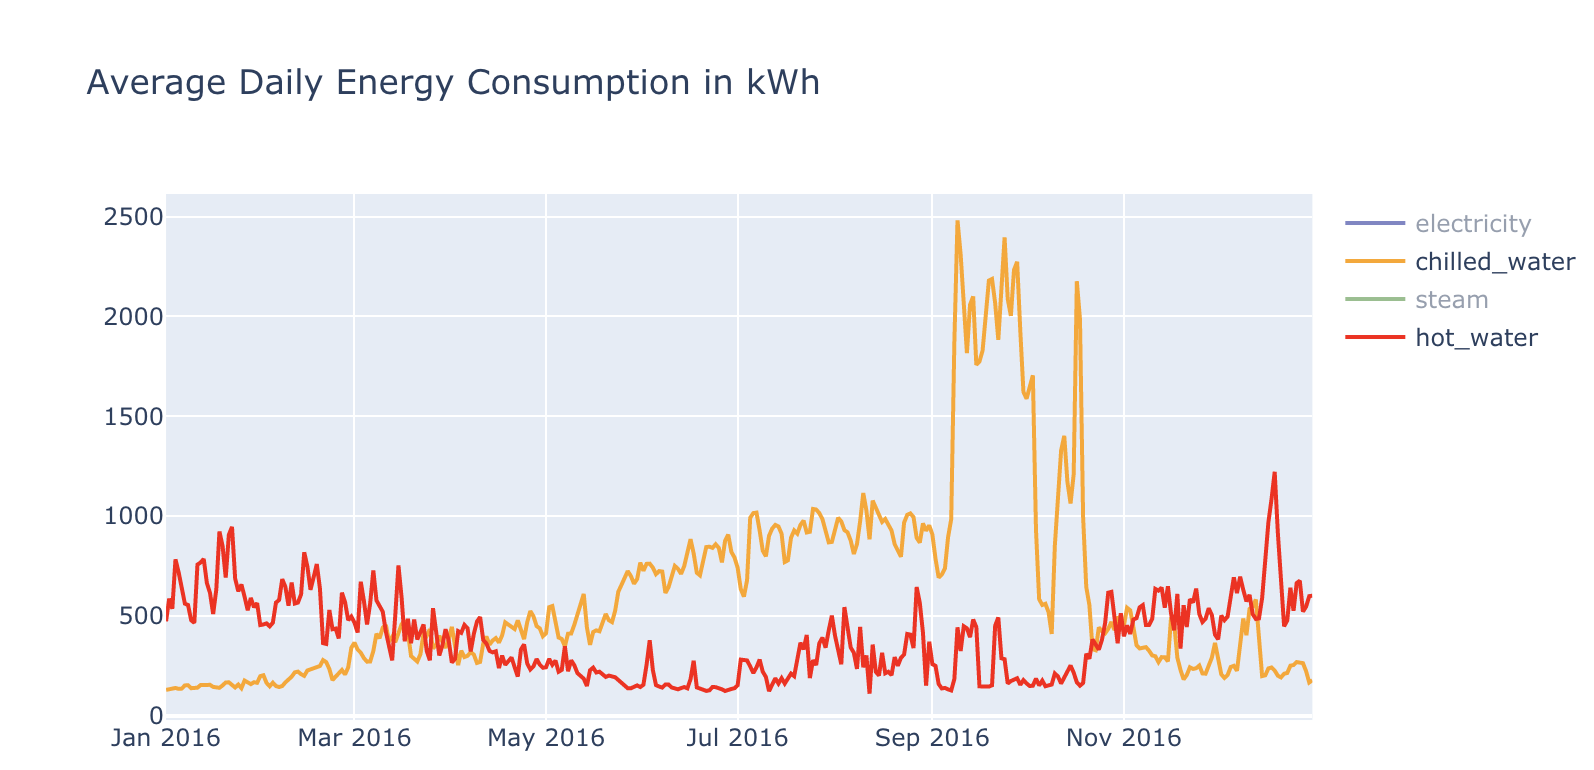

Fetching month, day of the week, day of month and hour from the timestamp column will help the model to catch the seasonality impact without using the timestamp column when training the model.

Additionally, I will add is_weekend and season (winter, spring, summer and fall) to emphasize seasonality in the model

In [30]:
# add month, day of week, day of month and hour

weather_data['month'] = weather_data['timestamp'].dt.month.astype(np.int8)  # January=1, December=12.
weather_data['day_of_week'] = weather_data['timestamp'].dt.dayofweek.astype(np.int8) #Monday=0, Sunday=6 
weather_data['day_of_month'] = weather_data['timestamp'].dt.day.astype(np.int8)
weather_data['hour'] = weather_data['timestamp'].dt.hour  # 0 to 23 hours

weather_data['is_weekend'] = weather_data.day_of_week.apply(lambda x : 1 if x>=5 else 0) 

In [31]:
def convert_season(month):
    if (month<=2) | (month==12):    # winter Season
        return 0
    elif (month >=3) & (month<=5 ): # Spring Season
        return 1
    elif (month >=6) & (month<=8 ):   # Summer Season
        return 2
    elif (month>=9) & (month <=11) : # Fall Season
        return 3

In [32]:
weather_data['season'] = weather_data.month.apply(convert_season)

#### 3.1.2.2. Impute missing values for weather variables 

We had a quite deal of missing values in the training dataset, except site_id and time_stamp:
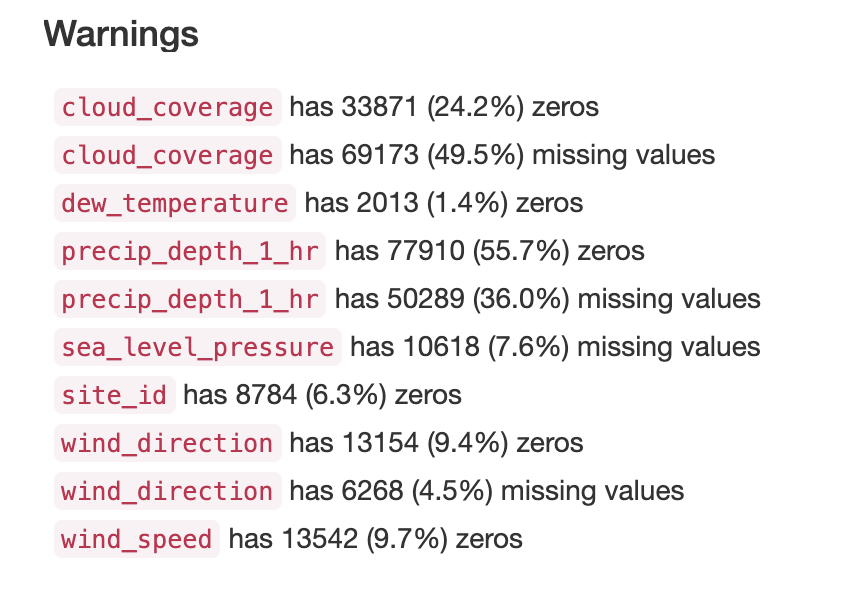

I will impute evey missing data from the daily mean of each site per month. This is the most logical and proven method (so far). For that, I am going to use update function of pandas.

I modified the function from this notebook for imputation. If daily means per month per site_id is not available then I will fill it with the mean values of the filler object created by grouping site_id, day and month.



#### Air temperature

In [33]:
#Reset Index for Update
weather_train = weather_data.set_index(['site_id','day_of_month','month'])


In [34]:
weather_train.head(50)

timestamp  air_temperature  \
site_id day_of_month month                                        
0       1            1     2016-01-01 00:00:00         25.00000   
                     1     2016-01-01 01:00:00         24.40625   
                     1     2016-01-01 02:00:00         22.79688   
                     1     2016-01-01 03:00:00         21.09375   
                     1     2016-01-01 04:00:00         20.00000   
                     1     2016-01-01 05:00:00         19.40625   
                     1     2016-01-01 06:00:00         21.09375   
                     1     2016-01-01 07:00:00         21.09375   
                     1     2016-01-01 08:00:00         20.59375   
                     1     2016-01-01 09:00:00         21.09375   
                     1     2016-01-01 10:00:00         21.09375   
                     1     2016-01-01 11:00:00         20.59375   
                     1     2016-01-01 12:00:00         18.90625   
                     1     2016-01-01 13:00:00         20.00000   
                     1     2016-01-01 14:00:00         21.70312   
                     1     2016-01-01 15:00:00         23.90625   
                     1     2016-01-01 16:00:00         26.09375   
                     1     2016-01-01 17:00:00         26.70312   
                     1     2016-01-01 18:00:00         27.79688   
                     1     2016-01-01 19:00:00         28.29688   
                     1     2016-01-01 20:00:00         28.29688   
                     1     2016-01-01 21:00:00         27.79688   
                     1     2016-01-01 22:00:00         26.70312   
                     1     2016-01-01 23:00:00         25.59375   
        2            1     2016-01-02 00:00:00         24.40625   
                     1     2016-01-02 01:00:00         23.90625   
                     1     2016-01-02 02:00:00         22.20312   
                     1     2016-01-02 03:00:00         21.09375   
                     1     2016-01-02 04:00:00         20.59375   
                     1     2016-01-02 05:00:00         19.40625   
                     1     2016-01-02 06:00:00         18.90625   
                     1     2016-01-02 07:00:00         18.90625   
                     1     2016-01-02 08:00:00         18.90625   
                     1     2016-01-02 09:00:00         18.29688   
                     1     2016-01-02 10:00:00         18.90625   
                     1     2016-01-02 11:00:00         16.70312   
                     1     2016-01-02 12:00:00         15.60156   
                     1     2016-01-02 13:00:00         15.00000   
                     1     2016-01-02 14:00:00         16.09375   
                     1     2016-01-02 15:00:00         17.20312   
                     1     2016-01-02 16:00:00         17.79688   
                     1     2016-01-02 17:00:00         19.40625   
                     1     2016-01-02 18:00:00         20.59375   
                     1     2016-01-02 19:00:00         22.20312   
                     1     2016-01-02 20:00:00         22.79688   
                     1     2016-01-02 21:00:00         21.09375   
                     1     2016-01-02 22:00:00         20.00000   
                     1     2016-01-02 23:00:00         18.90625   
        3            1     2016-01-03 00:00:00         17.79688   
                     1     2016-01-03 01:00:00         16.70312   

                            cloud_coverage  dew_temperature  \
site_id day_of_month month                                    
0       1            1             6.00000         20.00000   
                     1                 nan         21.09375   
                     1             2.00000         21.09375   
                     1             2.00000         20.59375   
                     1             2.00000         20.00000   
                     1                 nan         19.40625   
                     1             6.00000      

In [35]:
# create dataframe of daily means per site id
air_temperature_filler = pd.DataFrame(weather_train.groupby(['site_id','day_of_month','month'])
                                      ['air_temperature'].mean(),
                                      columns=["air_temperature"])
print(air_temperature_filler.isna().sum())
print(air_temperature_filler.head())

air_temperature    0
dtype: int64
                            air_temperature
site_id day_of_month month                 
0       1            1             23.34375
                     2             20.50000
                     3             19.20312
                     4             25.65625
                     5             25.28125


In [36]:
# create dataframe of air_temperature to fill
temporary_df = pd.DataFrame({'air_temperature': weather_train.air_temperature})

#update NA air_temperature values
temporary_df.update(air_temperature_filler, overwrite=False)
print(temporary_df.head())

# update in the weather train dataset
weather_train['air_temperature'] = temporary_df['air_temperature']


                            air_temperature
site_id day_of_month month                 
0       1            1             25.00000
                     1             24.40625
                     1             22.79688
                     1             21.09375
                     1             20.00000


In [37]:
del temporary_df, air_temperature_filler
gc.collect()

20

#### Cloud Coverage

In [38]:
# create dataframe of daily means per site id
cloud_coverage_filler = pd.DataFrame(weather_train
                                         .groupby(['site_id','day_of_month','month'])
                                                    ['cloud_coverage'].mean(),
                                     columns=['cloud_coverage'])
cloud_coverage_filler.isna().sum()

cloud_coverage    1075
dtype: int64

there are still NA values, so first i will fill these NA values with rounded mean value as cloud_covergage takes only discrete values

In [39]:
round(cloud_coverage_filler.cloud_coverage.mean(),0)

2.0

In [40]:
cloud_coverage_filler.fillna( round(cloud_coverage_filler.cloud_coverage.mean(),0),
                              inplace=True)

#create dataframe of cloud coverage to fill
temporary_df = pd.DataFrame({'cloud_coverage' : weather_train.cloud_coverage})

# update NA cloud_coverage values
temporary_df.update(cloud_coverage_filler, overwrite=False)

#update in the weather train dataset
weather_train['cloud_coverage'] = temporary_df['cloud_coverage']

del temporary_df, cloud_coverage_filler
gc.collect()



0

#### Dew Temperature

In [41]:
dew_temperature_filler = pd.DataFrame(weather_train
                                         .groupby(['site_id','day_of_month','month'])['dew_temperature'].mean(),
                                     columns=['dew_temperature'])
dew_temperature_filler.isnull().sum()

dew_temperature    0
dtype: int64

In [42]:
#create dataframe of dew_temperatures to fill
temporary_df = pd.DataFrame({'dew_temperature':weather_train.dew_temperature})

#update NA dew_temperature values
temporary_df.update(dew_temperature_filler, overwrite=False)

#update in the weather train dataset
weather_train['dew_temperature'] = temporary_df['dew_temperature']

del temporary_df, dew_temperature_filler
gc.collect()


0

#### Precip Depth 1 Hour

In [43]:
# create filler dataframe for precip_depth_1_hr

precip_depth_filler = pd.DataFrame(weather_train
                                   .groupby(['site_id','day_of_month','month'])['precip_depth_1_hr'].mean(),
                                  columns=['precip_depth_1_hr'])

precip_depth_filler.isnull().sum()

precip_depth_1_hr    1709
dtype: int64

There are still NA values, so I will first fill NA values of the filler with the rounded mean value (because precip_depth_1_hour takes discrete values), as I did for cloud_coverage.

In [44]:
precip_depth_filler.fillna(round(precip_depth_filler.precip_depth_1_hr.mean(), 0),
                           inplace=True)

# create dataframe of precip_depth_1_hr to fill
temporary_df = pd.DataFrame({'precip_depth_1_hr': weather_train.precip_depth_1_hr})

#update NA precip_depth_1_hr values
temporary_df.update(precip_depth_filler, overwrite=False)

weather_train['precip_depth_1_hr'] = temporary_df.precip_depth_1_hr

del temporary_df, precip_depth_filler
gc.collect()

0

#### Sea Level Pressure

In [45]:
# create dataframe of daily means per site id
sea_level_filler = pd.DataFrame(weather_train
                                .groupby(['site_id','day_of_month','month'])
                                ['sea_level_pressure'].mean(),
                                columns=['sea_level_pressure'])
sea_level_filler.isna().sum()

sea_level_pressure    375
dtype: int64

There are still NA values, so I will first fill NA values of the filler with the mean value, as I did for cloud_coverage.

In [46]:
mean_sea_level_pressure = round(
                                sea_level_filler
                                ['sea_level_pressure']
                                .astype(float)
                                .mean(),2)

In [47]:
sea_level_filler.fillna(mean_sea_level_pressure, inplace=True)

# create dataframe of sea_level_pressure to fill
temporary_df = pd.DataFrame({'sea_level_pressure' : weather_train.sea_level_pressure})

# update NA sea_level_pressure values
temporary_df.update(sea_level_filler, overwrite=False)

# update in the weather train dataset
weather_train["sea_level_pressure"] = temporary_df["sea_level_pressure"]

del sea_level_filler, temporary_df
gc.collect()

0

#### Wind Direction

In [48]:
# create dataframe of daily means per site id
wind_direction_filler = pd.DataFrame(weather_train
                                     .groupby(['site_id','day_of_month','month'])
                                     ['wind_direction'].mean(),
                                     columns=['wind_direction'])
wind_direction_filler.isna().sum()

wind_direction    0
dtype: int64

In [49]:
wind_direction_filler.head(10)

wind_direction
site_id day_of_month month                
0       1            1           122.93750
                     2            92.62500
                     3           111.68750
                     4           185.37500
                     5           116.93750
                     6            80.50000
                     7           185.25000
                     8           122.06250
                     9           143.75000
                     10          120.43750

In [50]:
# create dataframe of wind_direction to fill
temporary_df = pd.DataFrame({'wind_direction' : weather_train.wind_direction})

# update NA wind_direction values
temporary_df.update(wind_direction_filler, overwrite=False)

# update in the weather train dataset
weather_train["wind_direction"] = temporary_df["wind_direction"]



In [51]:
temporary_df.head(20)


wind_direction
site_id day_of_month month                
0       1            1             0.00000
                     1            70.00000
                     1             0.00000
                     1             0.00000
                     1           250.00000
                     1             0.00000
                     1             0.00000
                     1           210.00000
                     1             0.00000
                     1           290.00000
                     1             0.00000
                     1             0.00000
                     1           210.00000
                     1             0.00000
                     1             0.00000
                     1           210.00000
                     1           210.00000
                     1           230.00000
                     1           200.00000
                     1           180.00000

In [52]:
del temporary_df, wind_direction_filler
gc.collect()

40

#### Wind Speed

In [53]:
# create dataframe of daily means per site id
wind_speed_filler = pd.DataFrame(weather_train
                                 .groupby(['site_id','day_of_month','month'])
                                 ['wind_speed'].mean(),
                                 columns=['wind_speed'])
wind_speed_filler.isna().sum()

wind_speed    0
dtype: int64

In [54]:
# create dataframe of wind_speed to fill
temporary_df = pd.DataFrame({'wind_speed' : weather_train.wind_speed})

# update NA wind_speed values
temporary_df.update(wind_speed_filler, overwrite=False)

# update in the weather train dataset
weather_train["wind_speed"] = temporary_df["wind_speed"]

del temporary_df, wind_speed_filler
gc.collect()

0

In [55]:
# check if NA values left
weather_train.isna().sum()

timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
day_of_week           0
hour                  0
is_weekend            0
season                0
dtype: int64

#### Reset indexes to transfrom weather dataframe to original form

In [56]:
weather_train = weather_train.reset_index()

In [57]:
weather_train.head()

,site_id,day_of_month,month,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day_of_week,hour,is_weekend,season
0,0,1,1,2016-01-01 00:00:00,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,0.00000,4,0,0,0
1,0,1,1,2016-01-01 01:00:00,24.40625,4.28516,21.09375,-1.00000,1020.00000,70.00000,1.50000,4,1,0,0
2,0,1,1,2016-01-01 02:00:00,22.79688,2.00000,21.09375,0.00000,1020.00000,0.00000,0.00000,4,2,0,0
3,0,1,1,2016-01-01 03:00:00,21.09375,2.00000,20.59375,0.00000,1020.00000,0.00000,0.00000,4,3,0,0
4,0,1,1,2016-01-01 04:00:00,20.00000,2.00000,20.00000,-1.00000,1020.00000,250.00000,2.59961,4,4,0,0


### 3.1.2.3. Convert wind direction


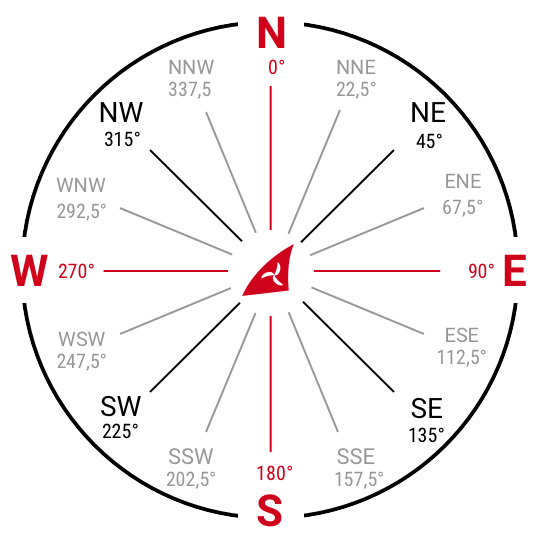
Recall that, wind_direction values span between 0 and 365 representing compass direction. I will aggreagte wind_direction values under 0, 1, 2 and 3 each for Northeast, Southeast, Southwest and Northwest directions.

After converting to categorical data, I am going to drop wind_direction column

In [58]:
def convert_direction(degrees):
    if degrees <= 90:
        return 0
    # as norteast direction
    elif degrees <= 180:
        return 1
    # as southeast direction
    elif degrees <= 270:
        return 2
    # as southwest direction
    elif degrees <= 360:
        return 3
    # as northwest direction

In [59]:
weather_train['wind_compass_direction'] = weather_train.wind_direction.apply(convert_direction)
weather_train.drop(columns='wind_direction',inplace=True)

### 3.1.3. Mean of numeri feature variables

In [60]:
#I am going to combine the mean of numeric weather variables.

weather_variables = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr',
                     'sea_level_pressure', 'wind_speed']

for i,j in combinations(weather_variables,2):
    train['mean'+i+'_'+j] = ((weather_train[i]) + (weather_train[j]))/2

### 3.1.4. Merge Dataframes

In [61]:
train = train.merge(building, on='building_id', how='left')

In [62]:
train = train.merge(weather_train, on=['site_id','timestamp'], how='left')
train.head()

,building_id,meter,timestamp,meter_reading,meanair_temperature_cloud_coverage,meanair_temperature_dew_temperature,meanair_temperature_precip_depth_1_hr,meanair_temperature_sea_level_pressure,meanair_temperature_wind_speed,meancloud_coverage_dew_temperature,meancloud_coverage_precip_depth_1_hr,meancloud_coverage_sea_level_pressure,meancloud_coverage_wind_speed,meandew_temperature_precip_depth_1_hr,meandew_temperature_sea_level_pressure,meandew_temperature_wind_speed,meanprecip_depth_1_hr_sea_level_pressure,meanprecip_depth_1_hr_wind_speed,meansea_level_pressure_wind_speed,site_id,primary_use,square_feet,building_age,day_of_month,month,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,day_of_week,hour,is_weekend,season,wind_compass_direction
0,0,0,2016-01-01,0.00000,15.50000,22.50000,12.41406,522.00000,12.50000,13.00000,2.91211,513.00000,3.00000,9.91406,520.00000,10.00000,509.75000,-0.08698,509.75000,0,0,7432,12.00000,1.00000,1.00000,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000
1,1,0,2016-01-01,0.00000,14.34375,22.75000,11.70312,522.00000,12.95312,12.68750,1.64258,512.00000,2.89258,10.04688,520.50000,11.29688,509.50000,0.25000,510.75000,0,0,2720,16.00000,1.00000,1.00000,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000
2,2,0,2016-01-01,0.00000,12.39844,21.93750,11.39844,521.50000,11.39844,11.54688,1.00000,511.00000,1.00000,10.54688,520.50000,10.54688,510.00000,0.00000,510.00000,0,0,5376,29.00000,1.00000,1.00000,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000
3,3,0,2016-01-01,0.00000,11.54688,20.84375,10.54688,520.50000,10.54688,11.29688,1.00000,511.00000,1.00000,10.29688,520.50000,10.29688,510.00000,0.00000,510.00000,0,0,23685,18.00000,1.00000,1.00000,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000
4,4,0,2016-01-01,0.00000,11.00000,20.00000,9.50000,520.00000,11.29688,11.00000,0.50000,511.00000,2.30078,9.50000,520.00000,11.29688,509.50000,0.79980,511.25000,0,0,116607,45.00000,1.00000,1.00000,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000


In [63]:
print('Number of unique columns in a train dataset', train.shape[1])

Number of unique columns in a train dataset 36


##### lets check for the missing values

In [64]:
train.isnull().sum()

building_id                                        0
meter                                              0
timestamp                                          0
meter_reading                                      0
meanair_temperature_cloud_coverage          20076327
meanair_temperature_dew_temperature         20076327
meanair_temperature_precip_depth_1_hr       20076327
meanair_temperature_sea_level_pressure      20076327
meanair_temperature_wind_speed              20076327
meancloud_coverage_dew_temperature          20076327
meancloud_coverage_precip_depth_1_hr        20076327
meancloud_coverage_sea_level_pressure       20076327
meancloud_coverage_wind_speed               20076327
meandew_temperature_precip_depth_1_hr       20076327
meandew_temperature_sea_level_pressure      20076327
meandew_temperature_wind_speed              20076327
meanprecip_depth_1_hr_sea_level_pressure    20076327
meanprecip_depth_1_hr_wind_speed            20076327
meansea_level_pressure_wind_speed           20

After the merge we still have some null values, due to the fact that train dataset has more observations than the tweather_train dataset. I am going to keep it as is for now, and impute missing values before creating the ML models

## 3.2. Feature Selection and Further Imputation

There are several methods and algorithms available for feature selection:

* removing highly collinear features
* principal component analysis
* functions in the feature selection class from from scikit-learn and so on...

As a quick and dirty solution and to start with I am going to look at pearson coefficients correlations. This is not the best solution for feature selection as it only considers the correlation between one feature to the target, one at a time, rather than considering the consolidated effect of the features to the target.

### 3.2.1 Pearsons coefficient of two features

I am going list how closely related each feature to the target. To do that, I am going to create pearson coefficients dataframe.

A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related (source : https://www.spss-tutorials.com/pearson-correlation-coefficient/). So as it gets closer to 1 or -1, the correlation gets stronger.

In [65]:
correlations_transformed = train.corr()


In [66]:
# use only 'meter_reading' column
correlations_transformed = pd.DataFrame(correlations_transformed['meter_reading']).reset_index()

# format the column names
correlations_transformed.columns = ['Feature','Correlation with meter_reading']
corr_df = correlations_transformed[correlations_transformed['Feature']!='meter_reading']
corr_df = corr_df.sort_values(by='Correlation with meter_reading',ascending=True)


In [67]:
corr_df

,Feature,Correlation with meter_reading
19,primary_use,-0.00994
23,month,-0.00671
28,sea_level_pressure,-0.00421
24,air_temperature,-0.00414
33,season,-0.00336
26,dew_temperature,-0.00333
17,meansea_level_pressure_wind_speed,-0.00170
10,meancloud_coverage_sea_level_pressure,-0.00168
6,meanair_temperature_sea_level_pressure,-0.00126
32,is_weekend,-0.00114


Strongest correlation we get is -0.1 and 0.2 which is not as high as I expected. I am going to try looking at the correlations with the natural logarithm of the meter reading+1 using np.log1p. This might help, as it helped for the visualization case

In [68]:
# add log(meter_reading +1) column 

train['log_meter_reading'] = np.log1p(train.meter_reading)
correlations_transformed = train.corr()

In [69]:
# use only 'meter_reading' column
correlations_transformed = pd.DataFrame(correlations_transformed['log_meter_reading']).reset_index()

# format the column names
correlations_transformed.columns = ['Feature','Correlation with log_meter_reading']
corr_df = correlations_transformed[correlations_transformed['Feature']!='log_meter_reading']
corr_df = corr_df.sort_values(by='Correlation with log_meter_reading',ascending=True)
corr_df


,Feature,Correlation with log_meter_reading
21,building_age,-0.06354
19,primary_use,-0.06264
32,is_weekend,-0.03258
29,wind_speed,-0.03256
25,cloud_coverage,-0.02605
30,day_of_week,-0.02584
17,meansea_level_pressure_wind_speed,-0.01555
34,wind_compass_direction,-0.01542
10,meancloud_coverage_sea_level_pressure,-0.01257
11,meancloud_coverage_wind_speed,-0.01062


***Some Notes on Collinearity:***
Usually a data scientist don't want highly collinear features going into the model.

I dropped the original feature if I have generated a new one. There are some collinear features left though from the original dataset: site_id & building_id and air_temperature & dew_temperature.

As both feature sets play a major role determining log_meter_reading values I am going to keep both sets, and add precip_depth_1_hr additionally.

For the feautre selection, if pearson coeffiecient is greater than the absolute value of 0.004, I will keep that feature, and this method includes meter_reading in the feature set so I replace it and include the original feature precip_depth_1_hr.

In [70]:
initial_feature_list = corr_df[(corr_df['Correlation with log_meter_reading']>= 0.004) | 
                        (corr_df['Correlation with log_meter_reading']<= -0.004)]['Feature'].tolist()

In [71]:
# we included meter_reading in the initial feature set
# which is not a feature
# replace meter_reading with precip_depth_1_hr
for n, i in enumerate(initial_feature_list):
    if i=='meter_reading':
        initial_feature_list[n] = 'precip_depth_1_hr'

initial_feature_list

['building_age',
 'primary_use',
 'is_weekend',
 'wind_speed',
 'cloud_coverage',
 'day_of_week',
 'meansea_level_pressure_wind_speed',
 'wind_compass_direction',
 'meancloud_coverage_sea_level_pressure',
 'meancloud_coverage_wind_speed',
 'meanprecip_depth_1_hr_sea_level_pressure',
 'sea_level_pressure',
 'meanair_temperature_sea_level_pressure',
 'air_temperature',
 'day_of_month',
 'dew_temperature',
 'hour',
 'season',
 'month',
 'meter',
 'precip_depth_1_hr',
 'building_id',
 'site_id',
 'square_feet']

In [72]:
del corr_df, correlations_transformed
gc.collect()

20

### Extract columns for X and Y

In [73]:
X = train[initial_feature_list].copy()
y = train['log_meter_reading']

In [74]:
del weather_data, building, weather_train
gc.collect()

40

In [75]:
print("Pearson coefficient based feature selection leaves us with {} features.".
      format(len(X.columns)))

Pearson coefficient based feature selection leaves us with 24 features.


### 3.2.2.Imputation of training dataset

Recall that, although I performed imputation on the train datasets individually we still have some NA values in the training dataset. None of the machine learning models can work with NA values, I am going to replace NA values. To replace I am going to use ```fillna``` function for simplicity and to avoid data leakage. With this method propagate last valid observation forward to next valid backfill.

This isa benefical point because, it prevents future data leaking into the training dataset. Preventing data leakage is important in a way defined by the machine learning mastery as follows:

```Data leakage is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the model being constructed.```

In [76]:
X = X.fillna(method='ffill', axis=1)

MemoryError: Unable to allocate 3.61 GiB for an array with shape (20216100, 24) and data type float64

In [ ]:
X.isnull().sum()

## 3.3. Split train set into training and validation set

Now we are going to split the training set into train and validation set.

Training set will be used to for the model to learn and capture the patterns and relate them to the target.
Validation set will be used for to understand how well the model generalizes learnings and captures to the newly introduced datasets.

The score of the evaluation metric obtained from the validation set can be an indicator of the test error.

I removed the timestamp column but it is still a time series data, meaning it has its own trends and seasonality factors. If this dataset was time independent, scikit-learn's train_test_split can be applied straightforward, but I want to keep my training and validation set sequential during the split.

So, I am going to use custom approach and split train and validation set as below. This way, I am going to keep first 75% of the columns as training set and last quarter will be validation set.

In [ ]:
# split train and validation set into 75(3/4) and 25 percent sequentially
X_train = X[:int(3 * X.shape[0] / 4)]
X_valid = X[int(3 * X.shape[0] / 4):]
y_train = y[:int(3 * y.shape[0] / 4)]
y_valid = y[int(3 * X.shape[0] / 4) :]

In [ ]:
# make sure train and validation sets shape align
print("Shape of the training set is: ", X_train.shape)
print("Shape of the validation set is: ", X_valid.shape)
print("Shape of the training labels are: ", y_train.shape)
print("Shape of the validation labels are: ", y_valid.shape)

## 3.4. Create a Baseline Metric

Before diving deep into the ML algorithms, I am going to calculate a common sense baseline. A common sense baseline is defined in this article(https://towardsdatascience.com/first-create-a-common-sense-baseline-e66dbf8a8a47) in simple terms, how a person has a knowledge in that field would solve the problem without using any data science tricks. Alternatively, as explained in this post(https://machinelearningmastery.com/implement-baseline-machine-learning-algorithms-scratch-python/), it can be a dummy or simple algorithm, consisting of few lines of code, to use as a baseline metric

Baseline metrics can be different(https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/) in regression and classification problems. For a regression problem it can be a central tendency measure as the result for all predictions, such as the mean or the median.

Since this a regression problem and competition's results will be evaluated(https://www.kaggle.com/c/ashrae-energy-prediction/overview/evaluation) for root mean squared logarithmic error,

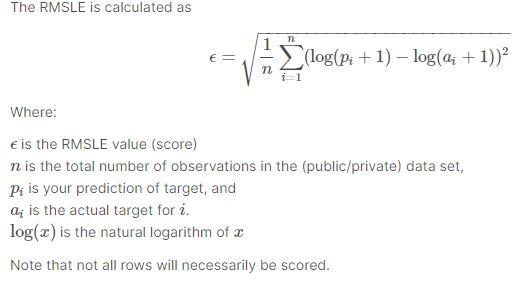


Baseline metrics are important in a way that, if a ML model cannot beat the simple and intuitive prediction of a person's or an algorithm's guess, the original problem needs reconsideration or training data needs reframing.

I have already applied log1p transformation to the target so throughout the project I am going to use RMSE (root mean squared error) as the single evaluation metric, which is:

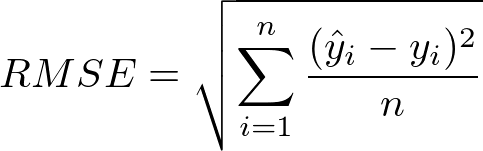

I am aware that those metrics are not the same, however I already decreased the variance in the target by applying log1p, and I expect a machine learning model to generate predictions within the same ranges as log1p of target. By measuring it with RMSE and predicting log1p of the target, I can get closer results to measuring with RMSLE and target.

difference between RMSE and RMSLE:https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(
                np.mean( 
                        np.square(y_true - y_pred)
                       )
                  )
    

In [ ]:
baseline_guess = np.median(y_train)
print('the baseline guess is a score of %0.2f' %baseline_guess)
print('Baseline Performance on the valid set = %0.4f' %rmse(y_valid,baesline_guess))


In [ ]:
print("Min value of meter_reading is:", y.min())
print("Median value of meter_reading is:", y.median())
print("Max value of meter_reading is:", y.max())

Although this is a pretty high baseline already let's see if any machine learning model can beat that score. 🧐



# 4. Compare Several Machine Learning Models

We did a heavy lifting job until here and faced the challenges of dealing with the big data, failed to use some libraries in feature selection due to the runtime errors. So this showed me that I need some robust algorithms for this project.

So I will try out three models: a regression model, a distance based model and a tree-based algorithm that can handle big datasets.

I am going to run simple linear regression, k nearest neighbors regressor and a light gradient boosting machine. Light gradient boosting machine already proved its robustness for big data in several notebooks in this competition. Here are some exmaple notebooks here: Notebook1(https://www.kaggle.com/rohanrao/ashrae-half-and-half/output), Notebook2(https://www.kaggle.com/isaienkov/lightgbm-fe-1-19).

***Function to evaluate model's performance on train and validation set with RMSLE***

In [ ]:
def fit_evaluate_model (model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train,y_train)
    y_predicted = model.predict(X_valid)
    return sqrt(mean_squared_error(y_valid, y_predicted))

## 4.1 Linear Regression

In [99]:
%%time

linear_regression = LinearRegression()
lr_rmse = fit_evaluate_model(linear_regression, X_train, y_train, X_valid, y_valid)
print("RMSE of the Linear Regresion model: ",lr_rmse)
del linear_regression, lr_rmse
gc.collect()

RMSE of the Linear Regresion model:  1.9895562452548898
Wall time: 22.5 s


20

Linear regression model guessed almost the same as the baseline model

## 4.2 Light GBM

In [103]:
%%time
lgbm_regressor = lgb.LGBMRegressor(random_state=42)
lgbm_rmse = fit_evaluate_model(lgbm_regressor , X_train, y_train, X_valid, y_valid)
print("RMSE of LGBM is: ",lgbm_rmse)

RMSE of LGBM is:  1.4426723670087538
Wall time: 2min 33s


In [104]:
del lgbm_regressor
del lgbm_rmse
gc.collect()


82

We achieved an improvement compared to linear regression. Linear regression yielded 1.98 of RMSE whereas light GBM's RMSE was 1.44. So, I will continue further tuning and adjusting the light gbm to achieve less RMSE.

Linear regression resulted in worse RMSE in less runtimes. Distance based algorithm had the highest run time. Light gbm has the highest run time, but generated the best result so far. This results are a concrete example that supports Rachel Tatman's (@rctatman) summary table of the machine learning algorithm's performances from PyCon 2019(https://www.youtube.com/watch?v=vTingdk_pVM : 4:19min).


## 4.4 Setting the inital parameters of light GBM

As light GBM outperformed linear regression, let's set some initial parameters for the algorithm. ***One note is that, when categorical features are specifically specified, light GBM works better***. I am going to treat some of the numeric features as categorical features. Here is how more categorical features work better in light gbm implementation:

    ```LightGBM offers good accuracy with integer-encoded categorical features. LightGBM applies Fisher (1958) to find the      optimal split over categories as described here. This often performs better than one-hot encoding.```

A good summary and how Light GBM works can be found in this blog post(https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d), which I also benefitted a lot for this project. Let's move to the implementation.

To decide on the inital parameters, I used the ones in this notebook(https://www.kaggle.com/rohanrao/ashrae-half-and-half/output).


In [106]:
train.head()

,building_id,meter,timestamp,meter_reading,meanair_temperature_cloud_coverage,meanair_temperature_dew_temperature,meanair_temperature_precip_depth_1_hr,meanair_temperature_sea_level_pressure,meanair_temperature_wind_speed,meancloud_coverage_dew_temperature,meancloud_coverage_precip_depth_1_hr,meancloud_coverage_sea_level_pressure,meancloud_coverage_wind_speed,meandew_temperature_precip_depth_1_hr,meandew_temperature_sea_level_pressure,meandew_temperature_wind_speed,meanprecip_depth_1_hr_sea_level_pressure,meanprecip_depth_1_hr_wind_speed,meansea_level_pressure_wind_speed,site_id,primary_use,square_feet,building_age,day_of_month,month,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,day_of_week,hour,is_weekend,season,wind_compass_direction,log_meter_reading
0,0,0,2016-01-01,0.00000,15.50000,22.50000,12.41406,522.00000,12.50000,13.00000,2.91211,513.00000,3.00000,9.91406,520.00000,10.00000,509.75000,-0.08698,509.75000,0,0,7432,12.00000,1.00000,1.00000,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,1,0,2016-01-01,0.00000,14.34375,22.75000,11.70312,522.00000,12.95312,12.68750,1.64258,512.00000,2.89258,10.04688,520.50000,11.29688,509.50000,0.25000,510.75000,0,0,2720,16.00000,1.00000,1.00000,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,2,0,2016-01-01,0.00000,12.39844,21.93750,11.39844,521.50000,11.39844,11.54688,1.00000,511.00000,1.00000,10.54688,520.50000,10.54688,510.00000,0.00000,510.00000,0,0,5376,29.00000,1.00000,1.00000,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,3,0,2016-01-01,0.00000,11.54688,20.84375,10.54688,520.50000,10.54688,11.29688,1.00000,511.00000,1.00000,10.29688,520.50000,10.29688,510.00000,0.00000,510.00000,0,0,23685,18.00000,1.00000,1.00000,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,4,0,2016-01-01,0.00000,11.00000,20.00000,9.50000,520.00000,11.29688,11.00000,0.50000,511.00000,2.30078,9.50000,520.00000,11.29688,509.50000,0.79980,511.25000,0,0,116607,45.00000,1.00000,1.00000,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [ ]:
categorical_features = ['building_id','site_id', 'meter', 'primary_use', 'wind_compass_direction',
                         'day_of_week','hour','is_weekend','season','month','day_of_month']

Here is the definition of the initially set parameters from the documentation:

***LGBM train Parameters:***

```feature_fraction```: controls the subsampling of features used for training (as opposed to subsampling the actual training data in the case of bagging). Smaller fractions reduce overfitting.

```num_boost_round```: Number of boosting iterations (default=100)

```boosting```: traditional Gradient Boosting Decision Tree

```num_leaves```: max number of leaves in one tree (default=31), to control tree complexity

```learning_rate```: the rate at which the model learning from the train set and achieving the best results (default=0.1), together with num_leaves used to control overfitting and underfitting

```reg_lambda```: parameter to apply L2 regularization (default=0)

In [ ]:
# transform training and testing  datasets in to lgbm datasets
train_dataset = lgb.Dataset(X_train, label=y_train, 
                            categorical_feature =categorical_features,
                            free_raw_data=False)


valid_dataset = lgb.Dataset(X_valid, label=y_valid, 
                           categorical_feature =categorical_features,
                            free_raw_data=False)

evals_result = {}

#inital parameterss of LGBM algo
initial_params = {'objective':'regression',
                  'boosting' :'gbdt',
                   'num_leaves': 60,
                   'learning_rate' :0.05,
                   'feature_fraction': 0.85,
                   'reg_lambda':'2',
                 'metric':{'rmse'}
                 }

In [ ]:
print("Building model with first 3 quarter pieces and evaluating the model on the last quarter:")
lgb_model = lgb.train(initial_params, 
                      train_set=train_dataset,
                      num_boost_round=1000,
                      valid_sets = [train_dataset, valid_dataset],
                      verbose_eval=100,
                      early_stopping_rounds=500,
                      evals_result= evals_result)

In [ ]:
print('Training and Validation Error of the Model')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

In the initial round we started with the 1.31 RMSE of the validation error, and in the final iteration we received 1.24 RMSE for the validation set, 0.12 point decrease, which is a 9 percent improvement overall.

Training error decreased more rapidly through the iterations from 0.95 to 0.68, 0.27 point decrease. This shows that the model learns faster from the training set and this is a consequence of model is trained with the same set of training set in every iteration.

We learned one thing from the initial parameter set round and the iterations:

* Both training and validation errors decreased, so if I set the num_boost rounds to a higher number, I would probably achieve less RMSE in the cost of higher runtimes.
* Gap between training and validation error increased, so this is a sign of we are overfitting, to eliminate the possibility of overfitting I will introduce cross-validation into the model rather than hyperparameter tuning.


In [114]:
del lgb_model
del train_dataset
del valid_dataset
del X_train
del X_valid
del y_train
del y_valid
gc.collect()

43

# 5. Perform Cross Validation on the Best Model

Cross validation allows the model to iteratively run on the different portions of the training set.

Recall that, I initially manually split train and test split into 4 pieces, allocated first 3 quarters as training set and last quarter as validation set.

Now, I am going to iteratively run the model on the 75% of the training data and see if RMSE will improve.

I am going to use KFold, and split X to 4 pieces and run light GBM iteratively on the each fold.

Here is a quick visual from scikit-learn's website of how Kfold performs splits:

In [118]:
# cretae kfold object and empty model and evaluation lists
kf = KFold(n_splits=4, shuffle=False)
models = []
evaluations = []

In [122]:
# dynamically split X and y with the k-fold split indexes

for train_index, valid_index in kf.split(X):
    X_train_rf = X.loc[train_index]
    y_train_rf = y.loc[train_index]
    
    X_valid_kf = X.loc[valid_index]
    y_valid_kf = y.loc[valid_index]
    
    d_train = lgb.Dataset(X_train_rf , label=y_train_rf,
                          categorical_feature =categorical_features,
                          free_raw_data=False)
    d_valid = lgb.Dataset(X_valid_kf , label=y_valid_kf,
                          categorical_feature =categorical_features,
                          free_raw_data=False)
    evaluation_result = {}
    
    model = lgb.train(initial_params,
                      train_set = d_train,
                      num_boost_round = 900,
                      valid_sets=[d_train, d_valid],
                      verbose_eval = 100,
                      early_stopping_rounds=500,
                      evals_result=evaluation_result)
    models.append(model)
    evaluations.append(evaluation_result)
    
    del X_train_kf, y_train_kf, X_valid_kf, y_valid_kf, d_train, d_valid
    gc.collect()

C:\Users\nehat4\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 0.99892	valid_1's rmse: 1.57456
[200]	training's rmse: 0.85963	valid_1's rmse: 1.50896
[300]	training's rmse: 0.821538	valid_1's rmse: 1.5
[400]	training's rmse: 0.802233	valid_1's rmse: 1.49576
[500]	training's rmse: 0.783623	valid_1's rmse: 1.49619
[600]	training's rmse: 0.764557	valid_1's rmse: 1.49385
[700]	training's rmse: 0.748553	valid_1's rmse: 1.49059
[800]	training's rmse: 0.733321	valid_1's rmse: 1.48787
[900]	training's rmse: 0.719167	valid_1's rmse: 1.48733
Did not meet early stopping. Best iteration is:
[900]	training's rmse: 0.719167	valid_1's rmse: 1.48733


NameError: name 'X_train_kf' is not defined

In [ ]:
print('Training and validation Error of First Fold')
ax = lgb.plot_metric(evaluation[0],metric='rmse')
plt.show()

In [ ]:
print('Training and Validation Error of the Second Fold')
ax = lgb.plot_metric(evaluations[1], metric='rmse')
plt.show()

In [ ]:
print('Training and Validation Error of the Third Fold')
ax = lgb.plot_metric(evaluations[2], metric='rmse')
plt.show()